In [1]:
import numpy as np
import os
import re

In [20]:
data = []
i = 0
while True:
    try:
        l = np.load('l{0}.npy'.format(i)).astype(np.float)
        gt = np.load('g{0}.npy'.format(i)).astype(np.float)
        costs = np.load('b{0}.npy'.format(i)).astype(np.float)
        acosts = np.load('a{0}.npy'.format(i)).astype(np.float)
    except:
        break
    max_disp = int(costs.shape[-1])
    image_width = costs.shape[1]
    image_height = costs.shape[0]
    data_size = costs.shape[0]*costs.shape[1]
    mask = np.ones_like(gt)
    mask[np.where(gt < 0)] = 0
    print gt.shape
    for y in xrange(image_height):
        for x in xrange(1,image_width):
            gp = gt[y,x-1]
            gn = gt[y,x]

            if gp == 0 or gp == -1 or gn == 0 or gn == -1:
                continue
            ft = [gn - gp,round(gn)-round(gp)]

            for img in [l,costs,acosts]:
                cp = img[y,x-1,:]
                cn = img[y,x,:]
                ft.append((cn - cp).sum())
            data.append(ft)
    for y in xrange(1,image_height):
        for x in xrange(image_width):
            gp = gt[y-1,x]
            gn = gt[y,x]

            if gp == 0 or gp == -1 or gn == 0 or gn == -1:
                continue
            ft = [gn - gp,round(gn)-round(gp)]

            for img in [l,costs,acosts]:
                cp = img[y-1,x,:]
                cn = img[y,x,:]
                ft.append(((cn - cp)).sum())
            data.append(ft)
    i = i + 1
    print len(data)
data = np.array(data)

(496L, 718L)
643944
(497L, 741L)
1268461
(481L, 707L)
1846574
(485L, 735L)
2396974
(476L, 699L)
2920507
(463L, 680L)
3453416
(486L, 720L)
4082395
(497L, 738L)
4681040
(375L, 450L)
4970474


In [21]:
print data.shape
import pandas as pd
data_f = pd.DataFrame(data)
#data_f = data[]
data_f[1] = (data_f[1] != 0.0).astype(np.int)
data_f = data_f.drop(0,1) # drop real gt
data_f = data_f.drop(4,1) # drop abs dif
no_grad = np.array(data_f[data_f[1] == 0])[:,1:]
grad = np.array(data_f[data_f[1] == 1])[:,1:]
total = np.array(data_f)
print no_grad.shape, grad.shape,total.shape

(4970474L, 5L)
(4664681L, 2L) (305793L, 2L) (4970474L, 3L)


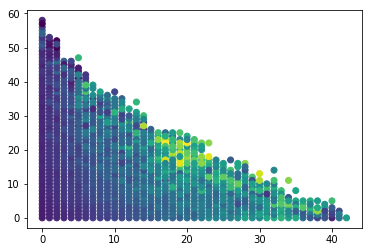

In [187]:
def hist2d(z,nbins=10):
    
    x = z[:,1]
    y = z[:,2]
    verification = z[:,0]
    print x.max(),x.min()
    print y.max(),y.min()
    print verification.max(),verification.min()
    _, xedges, yedges = np.histogram2d(x,y,bins=nbins)
    avgarr = np.zeros((nbins, nbins))
    H = np.zeros((nbins,nbins))
    # determine the X and Y bins each sample coordinate belongs to
    xbins = np.digitize(x, xedges[1:-1])
    ybins = np.digitize(y, yedges[1:-1])

    # calculate the bin sums (note, if you have very many samples, this is more
    # effective by using 'bincount', but it requires some index arithmetics
    for xb, yb, v in zip(xbins, ybins, verification):
        avgarr[yb, xb] += v
        H[yb,xb]+=1

    # replace 0s in H by NaNs (remove divide-by-zero complaints)
    # if you do not have any further use for H after plotting, the
    # copy operation is unnecessary, and this will the also take care
    # of the masking (NaNs are plotted transparent)
    divisor = H.copy()
    divisor[divisor==0.0] = np.nan

    # calculate the average
    avgarr /= divisor
    return avgarr,xedges,yedges,H

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib inline
grow =np.arange(grad.shape[0])
nrow = np.arange(no_grad.shape[0])
gidx = np.random.choice(grow,1000)
nidx = np.random.choice(nrow,1000)
plt.figure()
if False:
    plt.plot(abs(grad[gidx,0]),abs(grad[gidx,1]),ms=5,lw=0,marker='.')
    plt.plot(abs(no_grad[nidx,0]),abs(no_grad[nidx,1]),ms=5,lw=0,marker='.')

    plt.grid(True)
if False:
    plt.hexbin(abs(grad[:,0])+1,abs(grad[:,1])+1)
    plt.figure(figsize=(15,15))
    plt.hexbin(abs(no_grad[:,0])+1,abs(no_grad[:,1])+1)
if False:
    res,xbins,ybins,H = hist2d(abs(total),20)
    plt.imshow(res,origin='lower')
    plt.xlabel('color')
    plt.xticks(np.arange(20),np.unique(xbins))
    plt.yticks(np.arange(20),np.unique(ybins))
    plt.ylabel('sum disp diff')
    plt.colorbar()
    plt.figure()
    plt.imshow(res > 0.5,origin='lower')
    plt.figure()
    plt.imshow(H,origin='lower',norm=LogNorm())
    plt.colorbar()
if True:
    from collections import defaultdict
    cntr = defaultdict(float)
    prob = defaultdict(float)
    xscale = 0.1
    yscale = 0.01
    for z,x,y in abs(total):
        cntr[(int(x*xscale),int(y*yscale))] += z
        prob[(int(x*xscale),int(y*yscale))] += 1
    bad_keys = []
    for key in cntr:
        cntr[key] = cntr[key] / prob[key]
        if prob[key] < 15:
            bad_keys.append(key)
    for key in bad_keys:
        del cntr[key]
    x = []
    y = []
    c = []
    for key in cntr:
        x.append(key[0])
        y.append(key[1])
        c.append(cntr[key])
    plt.scatter(x,y,c=c)

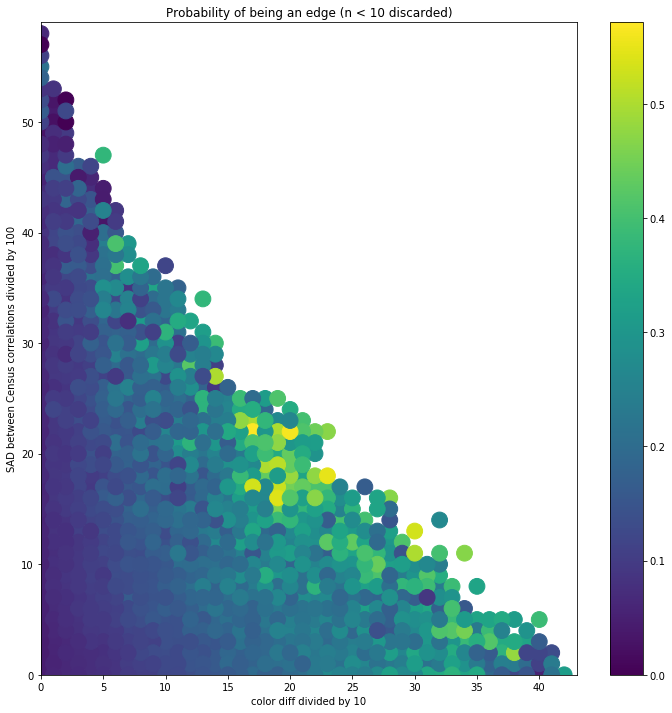

In [194]:
plt.figure(figsize=(12,12))
plt.scatter(x,y,c=c,s=250)
plt.title('Probability of being an edge (n < 10 discarded)')
plt.ylabel('SAD between Census correlations divided by 100')
plt.xlabel('color diff divided by 10')
plt.grid(False)
plt.xlim(0,43)
plt.ylim(0,59)
plt.colorbar()

In [161]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
abs_x = abs(total[:,1:])
abs_xy = (abs_x[:,0]*abs_x[:,1]).reshape([-1,1])
X = np.hstack([abs_x,abs_xy])
y = total[:,0].astype(np.int)
model = RandomForestClassifier(n_jobs=-1,max_depth=4)#SGDClassifier(n_jobs=-1,loss='hinge',penalty='l2',fit_intercept=True,class_weight='balanced')
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [158]:
model.coef_,model.intercept_

(array([[-779.24280764, -153.22733819,   17.71625922]]),
 array([-4616.30418092]))

In [162]:
model.score(X,y)

0.93847810088132444